In [27]:
import zipfile
import os
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.models import resnet18, ResNet18_Weights
import pickle as pkl

In [13]:
# Преобразования данных для трейн выборок
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ColorJitter(),
    T.RandomRotation(90),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Преобразования данных для трейн выборок
valid_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
full_train_dataset = datasets.ImageFolder(root='../data/weather')

In [15]:
# Разделение на обучающую и валидационную выборки
train_size = int(0.8 * len(full_train_dataset)) # 80% датасета на трейн
val_size = len(full_train_dataset) - train_size # остаток для валидации
generator42 = torch.Generator().manual_seed(42)
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, val_size],generator=generator42)

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = valid_transforms

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


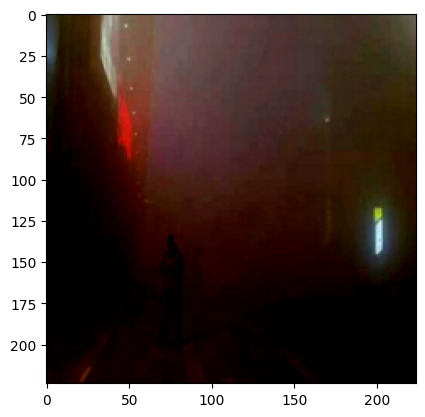

In [17]:
for images, labels in train_loader:
    image_size = images[0]
    break

plt.imshow(torch.permute(image_size, (1, 2, 0)))

In [18]:
class myRegNet(nn.Module):
    def __init__(self):
         super().__init__()
         self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
         self.model.fc = nn.Linear(512, 11)
         # замораживаем слои
         for i in self.model.parameters():
             i.requires_grad = False
        # размораживаем только последний, который будем обучать
         self.model.fc.weight.requires_grad = True
         self.model.fc.bias.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [19]:
DEVICE = 'cpu'
model = myRegNet()
model.to(DEVICE);

In [20]:
# def check_labels(loader, num_classes):
#     for batch_idx, (images, labels) in enumerate(loader):
#         if labels.min().item() < 0 or labels.max().item() >= num_classes:
#             print(f"Label out of range in batch {batch_idx}: {labels}")
#             return False
#     return True

# num_classes = 11

# # Проверка меток в train_loader
# if check_labels(train_loader, num_classes):
#     print("All labels in train_loader are within the valid range.")
# else:
#     print("Some labels in train_loader are out of range.")

# # Проверка меток в valid_loader
# if check_labels(val_loader, num_classes):
#     print("All labels in valid_loader are within the valid range.")
# else:
#     print("Some labels in valid_loader are out of range.")


In [21]:
# train_epoch_acc = []
# train_epoch_losses = []
# valid_epoch_losses = []
# valid_epoch_acc =[]
# for epoch in range(6):
#     model.train()
#     loss_batch = []
#     acc_batch  = []

#     for images, labels in train_loader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)

#         preds = model(images).squeeze(-1)
#         # print(preds.shape, labels.shape, preds.squeeze(-1).shape)

#         loss = criterion(preds, labels)
#         # print(loss.item())

#         loss_batch.append(loss.item())
#         accuracy = (preds.argmax(dim=1) == labels).float().mean().cpu().numpy()

#        # accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
#         acc_batch.append(accuracy)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     train_epoch_losses.append(np.mean(loss_batch))
#     train_epoch_acc.append(np.mean(acc_batch))

#     model.eval()
#     loss_batch = []
#     acc_batch  = []
#     for images, labels in val_loader:
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE)
#         preds = model(images).squeeze(-1)

#         loss = criterion(preds, labels)
#         loss_batch.append(loss.item())

#         accuracy = (preds.argmax(dim=1) == labels).float().mean().cpu().numpy()

#        # accuracy = (preds.sigmoid().round() == labels).cpu().numpy().mean()
#         acc_batch.append(accuracy)

#     valid_epoch_losses.append(np.mean(loss_batch))
#     valid_epoch_acc.append(np.mean(acc_batch))

#     print(f'Epoch: {epoch}  loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}')
#     print(f'\t   metrics_train: {train_epoch_acc[-1]:.3f}, metrics_valid: {valid_epoch_acc[-1]:.3f}')

In [22]:
# Определяем цикл обучения
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        history = None
        ) -> dict:
    '''
    model: pytorch model - model to train
    epochs: int          - number of epochs
    plot_every: int      - plot every N iterations
    '''

    # будем сохранять значения точности и лосса в history
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    # определяем текущую эпоху обучения
    start_epoch = len(history['train_accs'])
    for epoch in range(start_epoch+1, start_epoch+epochs+1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = []
        for samples, labels in train_loader:

            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            preds = model(samples)

            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((preds.argmax(dim=1) == labels).float().mean().cpu().numpy())

        history['train_losses'].append(np.mean(batch_losses))
        history['train_accs'].append(np.mean(batch_accs))

        # Validation
        model.eval()

        batch_accs = []
        batch_losses = []
        for samples, labels in valid_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():
                preds = model(samples)
            loss = criterion(preds, labels)
            batch_losses.append(loss.item())
            batch_accs.append((preds.argmax(dim=1) == labels).float().mean().cpu().numpy())
        history['valid_accs'].append(np.mean(batch_accs))
        history['valid_losses'].append(np.mean(batch_losses))

        print(
            f'train: accuracy {history["train_accs"][-1]:.4f}, loss {history["train_losses"][-1]:.4f}\n'
            f'valid: accuracy {history["valid_accs"][-1]:.4f}, loss {history["valid_losses"][-1]:.4f}'
        )
        print(f'{"-"*35}')
        print()

    return history

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
logs = fit_model(model,10,optimizer)

------------- Epoch 1 -------------
train: accuracy 0.6686, loss 1.0632
valid: accuracy 0.8270, loss 0.5963
-----------------------------------

------------- Epoch 2 -------------
train: accuracy 0.8383, loss 0.5347
valid: accuracy 0.8518, loss 0.4828
-----------------------------------

------------- Epoch 3 -------------
train: accuracy 0.8512, loss 0.4588
valid: accuracy 0.8632, loss 0.4431
-----------------------------------

------------- Epoch 4 -------------
train: accuracy 0.8684, loss 0.4065
valid: accuracy 0.8646, loss 0.4227
-----------------------------------

------------- Epoch 5 -------------
train: accuracy 0.8863, loss 0.3585
valid: accuracy 0.8712, loss 0.4082
-----------------------------------

------------- Epoch 6 -------------
train: accuracy 0.8888, loss 0.3405
valid: accuracy 0.8626, loss 0.4390
-----------------------------------

------------- Epoch 7 -------------
train: accuracy 0.8947, loss 0.3270
valid: accuracy 0.8726, loss 0.4038
----------------------

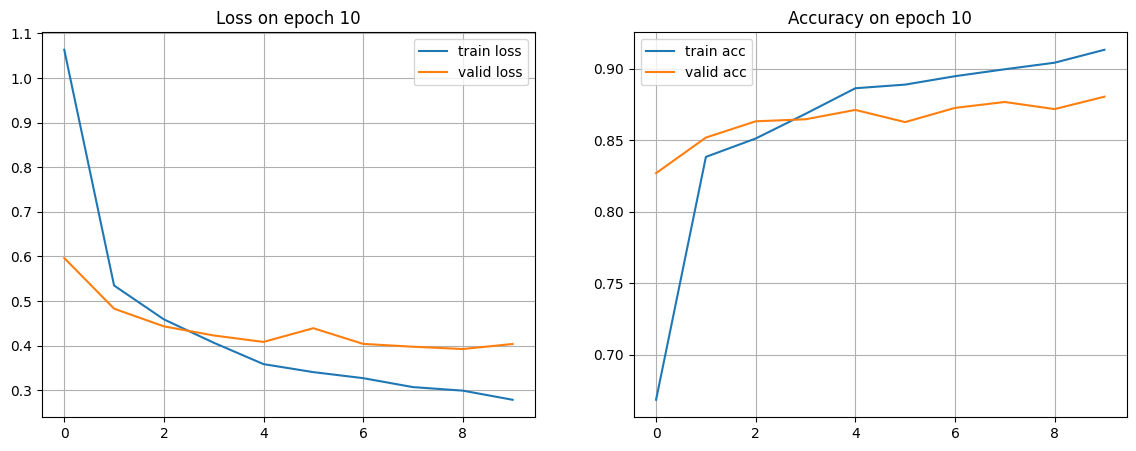

In [24]:
# Зададим функцию для отрисовки графиков

# зададим функцию рисования графиков
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].legend()

    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].legend()

    plt.show()

plot_history(logs)

In [25]:
# torch.save(model.state_dict(), 'model_weights.pth')
# torch.save(model, 'model.pth')

In [28]:
# with open('hist_dict.pickle', 'wb') as file:
#     pkl.dump(logs, file)

# class_to_idx = full_train_dataset.class_to_idx
# with open('class_dict.pickle', 'wb') as file:
#     pkl.dump(class_to_idx, file)